In [197]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
import torch.autograd as autograd
import importlib
import Extract_data
importlib.reload(Extract_data)
import Inference
importlib.reload(Inference)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import CenterLoss as cl
import torch.nn.functional as F
import random
import Model
importlib.reload(Model)
import sys

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#n is the number of times the data is iterated repeatedly to extract data
def get_data(data,n_times):
    chunks,labels,_=Extract_data.get_batch(data,bs=len(data),sr=sr,segment_len=segment_len,step=step)
    for i in range(n):
        c,l,_=Extract_data.get_batch(data,bs=len(data),sr=sr,segment_len=segment_len,step=step)
        chunks=chunks.append(c)
        labels=np.append(labels,l,axis=0)
    return chunks,labels

def get_acc(model,data):
    comb_model.eval()
    chunks,labels=get_data(data,n_times=5)
    correct_num=0
    for i in range(len(chunks)):
        d=torch.from_numpy(chunks.iloc[i])
        d=torch.unsqueeze(d,dim=0).float()
        d=d.to(device)
        l=torch.from_numpy(labels)
        l=l.to(device)
        l=l[i].view(1).item()
        #print(l)
        pred=model(d)
        predmax=torch.max(pred,1).indices.item()
        #print(predmax)
        #print('_____')
        if(predmax==l):
            correct_num+=1
    comb_model.train()
    return correct_num/len(data)



'''
UCI data labels
0 WALKING           
1 WALKING_UPSTAIRS  
2 WALKING_DOWNSTAIRS
3 SITTING           
4 STANDING          
5 LAYING            
6 STAND_TO_SIT      
7 SIT_TO_STAND      
8 SIT_TO_LIE        
9 LIE_TO_SIT        
10 STAND_TO_LIE      
11 LIE_TO_STAND 
'''

'''
UTWNETE data

walk    11111  0
stand   11112  1 
jog     11113  2
sit     11114  3
bike    11115  4
upstairs 11116  5
downstairs 11117  6
type    11118  7
write   11119  8
coffee  11120  9
talk    11121  10
smoke   11122  11
eat     11123  12
'''

'\nUTWNETE data\n\nwalk    11111  0\nstand   11112  1 \njog     11113  2\nsit     11114  3\nbike    11115  4\nupstairs 11116  5\ndownstairs 11117  6\ntype    11118  7\nwrite   11119  8\ncoffee  11120  9\ntalk    11121  10\nsmoke   11122  11\neat     11123  12\n'

In [2]:
#load data from UTWNETE
data_df=Extract_data.get_UTWNETE_data()
activities={
    0:'walk',
    1:'stand',
    2:'jog',
    3:'sit',
    4:'bike',
    5:'upstairs',
    6:'downstairs',
    7:'type',
    8:'write',
    9:'drink',
    10:'talk',
    11:'smoke',
    12:'eat'
}

In [2]:
#load data from PAMAP2 dataset
data_df=Extract_data.get_PAMAP2_Data()
#interpolate NAN values
k=data_df['data'].apply(Extract_data.interpolate)

participants=np.unique(data_df['participant'])
groups=[participants[:3],participants[3:6],participants[6:]]

'''
#scaled to -1 +1
min_val,max_val=np.min(pred_df.apply(np.min,axis=0).values),np.max(pred_df.apply(np.max,axis=0).values)
scaled=pred_df.apply(get_global_standardized,args=[np.array([max_val]),np.array([min_val])],axis=1)
print(np.max(scaled.apply(np.max,axis=1)),np.min(scaled.apply(np.min,axis=1)))
pred_df=scaled
'''

activities={
    0:'other',
    1:'lying',
    2:'sitting',
    3:'standing',
    4:'walking',
    5:'running',
    6:'cycling',
    7:'Nordic walking',
    9:'watching TV',
    10:'computer work',
    11:'car driving',
    12:'ascending stairs',
    13:'descending stairs',
    16:'vacuum cleaning',
    17:'ironing',
    18:'folding laundry',
    19:'house cleaning',
    20:'playing soccer',
    24:'rope jumping'  
}

/home/lnw8px/models/HAR_research/center_loss/Extract_data.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['diff']=diffs


In [3]:
def get_activity_name(label,activities):
    return activities[label]
data_df['activity_name']=data_df['label'].apply(get_activity_name,args=[activities])
data_df['activity_vec']=0

In [4]:
'''
class divisions mentioned in paper
Few-Shot Learning-Based Human Activity Recognition by
Feng and Duarte
'''
seen_classes=['lying','standing','walking','running','ascending stairs','vacuum cleaning','rope jumping']
unseen_classes=['sitting','cycling','Nordic walking','descending stairs','ironing']

def get_Feng_seen_unseen(seen_group,unseen_group):
    seen_df=data_df[data_df['participant'].isin(seen_group)]
    unseen_df=data_df[data_df['participant'].isin(unseen_group)]

    seen_data=seen_df[seen_df['activity_name'].isin(seen_classes)]
    unseen_data=unseen_df[unseen_df['activity_name'].isin(unseen_classes)]

    seen_data['label']=Extract_data.get_remapped_labels(seen_data)
    unseen_data['label']=Extract_data.get_remapped_labels(unseen_data)
    
    return seen_data,unseen_data

In [5]:
def get_seen_unseen_data(num_unseen_classes):
    keys=list(activities.keys())
    random.shuffle(keys)
    unseen_classes=keys[0:num_unseen_classes]
    seen_classes=keys[num_unseen_classes:]
    seen_data=data_df[data_df['label'].isin(seen_classes)]
    unseen_data=data_df[data_df['label'].isin(unseen_classes)]

    seen_data['label']=Extract_data.get_remapped_labels(seen_data)
    unseen_data['label']=Extract_data.get_remapped_labels(unseen_data)

    return seen_data,unseen_data,unseen_classes

In [ ]:
LAMBDA=0.0005
segment_len_s=10
sr=100
discount=0.8
bs=4
num_embeddings=128
num_kernels=32
num_unseen_classes=5
num_samples=1

seen_data,unseen_data,unseen_classes=get_seen_unseen_data(num_unseen_classes)
train_df,test_df=Extract_data.divide_data(seen_data,ratio=0.9)
#initialize model
modelWork=Model.ModelWork(len(np.unique(train_df['activity_name'])),num_embeddings,
                         in_channels=6,
                         sr=sr,
                         segment_len_s=segment_len_s,
                         num_kernels=num_kernels)
max_acc,train_loss_list,train_word_loss_list,train_center_loss_list=modelWork.train(train_df,test_df,LAMBDA=LAMBDA,
                                                                                    ALPHA=0,
                                                                                    max_itr=10000,
                                                                                    discount=discount,
                                                                                    bs=bs)
print('model_acc='+str(max_acc))
data,labels,activity_name,_=Extract_data.get_n_times_cropped_data(unseen_data,bs=len(unseen_data),n_times=20,
                                                               sr=sr,
                                                               segment_len_s=segment_len_s)
data=data.to(device)
embedding,pred=modelWork.model(data)
embedding=embedding.detach().cpu().numpy()
d=pd.DataFrame()
d['data']=[f for f in embedding]
d['activity_name']=activity_name.values

d=d.rename(columns={'activity_name':'label'})
d['label_num']=Extract_data.get_remapped_labels(d)
d=d.rename(columns={'label_num':'label','label':'activity_name'})


eval_train_df,eval_test_df=Inference.divide_data(d,num_samples=num_samples)
total_acc,per_class_acc=Inference.train_similarity_classifier(eval_train_df,eval_test_df)
print('1 shot learning unseen data accuracy = '+str(total_acc))

In [198]:
model=modelWork.model

unique labels=[0 1 2 3 4 5 6 7]


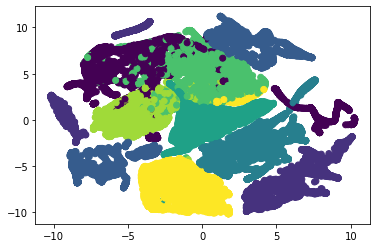

In [207]:
'''
observe clusters of train data
'''
data=train_df
data,labels,activity_name,_=Extract_data.get_n_times_cropped_data(data,bs=len(data),n_times=500,
                                                               sr=sr,
                                                               segment_len_s=segment_len_s)
data=data.to(torch.device("cpu"))
model=model.to(torch.device("cpu"))
features=modelWork.model(data)[0]

print('unique labels='+str(np.unique(labels.numpy())))


'''
reduce dimentions of features to 2 dimentions with tSNE and plot scatter
'''
features=features.detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=labels.numpy())

unique labels=[0 1 2 3 6 7]


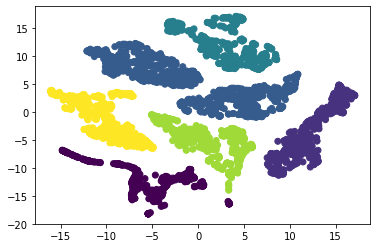

In [208]:
'''
observe clusters of test data
'''
data=test_df
data,labels,activity_name,_=Extract_data.get_n_times_cropped_data(data,bs=len(data),n_times=500,
                                                               sr=sr,
                                                               segment_len_s=segment_len_s)
data=data.to(torch.device("cpu"))
model=model.to(torch.device("cpu"))
features=modelWork.model(data)[0]

print('unique labels='+str(np.unique(labels.numpy())))


'''
reduce dimentions of features to 2 dimentions with tSNE and plot scatter
'''
features=features.detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=labels.numpy())

unique labels=[0 1 2 3 4]


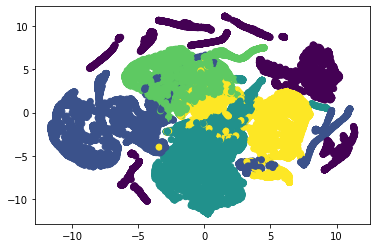

In [209]:
'''
observe clusters of unseen data
'''
data=unseen_data
data,labels,activity_name,_=Extract_data.get_n_times_cropped_data(data,bs=len(data),n_times=500,
                                                               sr=sr,
                                                               segment_len_s=segment_len_s)
data=data.to(torch.device("cpu"))
model=model.to(torch.device("cpu"))
features=modelWork.model(data)[0]

print('unique labels='+str(np.unique(labels.numpy())))


'''
reduce dimentions of features to 2 dimentions with tSNE and plot scatter
'''
features=features.detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=labels.numpy())

In [211]:
data=train_df[train_df.label==1]
data,labels,activity_name,_=Extract_data.get_n_times_cropped_data(data,bs=len(data),n_times=1000,
                                                               sr=sr,
                                                               segment_len_s=segment_len_s)
features=modelWork.model(data)[0]
centroid=torch.mean(features,dim=0)
centroid=torch.unsqueeze(centroid,dim=0)
centroid=torch.repeat_interleave(centroid,repeats=features.shape[0],dim=0)

dists=torch.sqrt(torch.sum(torch.square(centroid-features),dim=1)).detach().cpu()
dists=dists+(torch.rand(dists.shape[0])-0.5)*4
dists=dists.numpy()

(array([ 363., 1142., 1549., 1787., 1789., 1386.,  706.,  218.,   46.,
          14.]),
 array([-1.0117016 , -0.20380792,  0.60408574,  1.4119794 ,  2.219873  ,
         3.0277667 ,  3.8356605 ,  4.643554  ,  5.4514475 ,  6.2593412 ,
         7.067235  ], dtype=float32),
 <a list of 10 Patch objects>)

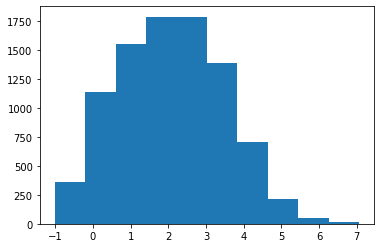

In [213]:
plt.hist(dists)